In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(SeuratData)
    library(patchwork)
    library(conos)
    library(dplyr)
})

Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning me

In [108]:
packageVersion('conos')

[1] ‘1.4.5’

In [103]:
covert_seurat_to_pagoda_app = function(
    SR,
    fname,
    app.title,
    n.cores=10
){
    library(pagoda2)
    library(igraph)
    
    p2 = basicP2proc(
        SR@assays$RNA@counts, 
        n.cores = n.cores
    )
    go.env <- p2.generate.human.go(p2)
    p2$clusters$PCA$seurat_cluster = as.factor(SR@meta.data$seurat_cluster)
    names(p2$clusters$PCA$seurat_cluster) = rownames(SR@meta.data)
    p2$embeddings$PCA$tSNE = as.matrix(SR@reductions$umap@cell.embeddings)
    p2$clusters$PCA$timepoint = as.factor(SR@meta.data$orig.ident)
    names(p2$clusters$PCA$timepoint) = rownames(SR@meta.data)
    p2$embeddings$PCA$tSNE = as.matrix(SR@reductions$umap@cell.embeddings)
    hdea <- p2$getHierarchicalDiffExpressionAspects(
        type='PCA',
        clusterName='multilevel',
        z.threshold=3, 
        n.cores = n.cores
    )
    extraWebMetadata = NULL
    metadata.forweb <- list();
    metadata.forweb$timepoint <- p2.metadata.from.factor(
        p2$clusters$PCA$timepoint,
        displayname='timepoint'
    )
    metadata.forweb$leiden <- p2.metadata.from.factor(
        p2$clusters$PCA$seurat_cluster,
        displayname='seurat_cluster'
    )
    metadata.forweb$multilevel <- p2.metadata.from.factor(
        p2$clusters$PCA$multilevel,
        displayname='multilevel'
    )
    metadata.forweb <- c(metadata.forweb, extraWebMetadata)
    genesets <- hierDiffToGenesets(hdea)
    appmetadata = list(apptitle=app.title)
    
    p2w = make.p2.app(p2, 
                      additionalMetadata = metadata.forweb, 
                      geneSets = genesets, 
                      dendrogramCellGroups = p2$clusters$PCA$multilevel, 
                      show.clusters=F, 
                      appmetadata = appmetadata
                     )

    p2w$serializeToStaticFast(binary.filename = fname)
    return(p2)
}

### Cell cycle genes

In [9]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes

### Make Seurat object from mouse neuroblastoma data

In [5]:
tumor.con = readRDS(
    glue::glue(
        '/home/meisl/Workplace/neuroblastoma/ThMYCN_210610',
        '/conos/conos/all.tumor_conos.rds'
))

In [6]:
raw.count.objs = lapply(tumor.con$samples, function(x){
  raw.count = x$misc$rawCounts
  mito.genes = grep(pattern = "^mt-", x = colnames(raw.count), value = TRUE, ignore.case = TRUE)
  rpl.genes = grep(pattern = "^rpl", x = colnames(raw.count), value = TRUE, ignore.case = TRUE)
  rps.genes = grep(pattern = "^rps", x = colnames(raw.count), value = TRUE, ignore.case = TRUE)
  genes.removed = union(mito.genes, rpl.genes)
  genes.removed = union(genes.removed, rps.genes)
  raw.count = raw.count[, setdiff(colnames(raw.count), genes.removed)]
  colnames(raw.count) = toupper( colnames(raw.count) )
  
  t(raw.count)
})

In [55]:
seurat.obj.list = lapply(names(raw.count.objs),function(sample.name)  CreateSeuratObject(
    counts = raw.count.objs[[sample.name]], 
    project = paste("mnb5",sample.name, sep="_"), 
    min.cells = 3, 
    min.features = 500
))

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”


In [56]:
names(seurat.obj.list) = names(raw.count.objs)

In [57]:
s.genes.selected = intersect(seurat.obj.list[[1]] %>% rownames,  s.genes )
g2m.genes.selected = intersect(seurat.obj.list[[1]] %>% rownames,  g2m.genes )

In [58]:
seurat.obj.list <- lapply(X = seurat.obj.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
    x <- ScaleData(x, features = rownames(x))
    x <- RunPCA(
        x, 
        features = VariableFeatures(x), 
        ndims.print = 6:10, 
        nfeatures.print = 10
    )
    x <-  CellCycleScoring(
        x, 
        s.features = s.genes.selected, 
        g2m.features = g2m.genes.selected, 
        set.ident = TRUE
    )
    
    x <-  ScaleData(
        x, 
        vars.to.regress = c("S.Score", "G2M.Score"), 
        features = VariableFeatures(x)
    )
    x
})

Centering and scaling data matrix

PC_ 6 
Positive:  PTPRCAP, CD7, IGHM, LY6D, CD209D, CD69, IL7R, IRF8, KLK1, BST2 
Negative:  LYZ2, CLEC4A3, LST1, PLA2G7, CD300C2, IL1B, GNGT2, WFDC17, MSRB1, IFITM3 
PC_ 7 
Positive:  NHP2, NEFL, UNG, NEFM, SRM, PRDX6, UBE2C, PTTG1, LYAR, ODC1 
Negative:  MALAT1, MEG3, CHGA, NPY, TH, NUSAP1, DBH, FOS, CALY, ADARB2 
PC_ 8 
Positive:  CD209D, IRF8, KLK1, BST2, CTSH, RNASE6, H2-AB1, H2-AA, CD7, H2-EB1 
Negative:  CD3G, TRBC2, AW112010, CD3D, LTB, MS4A4B, CD2, TRAC, SHISA5, CD52 
PC_ 9 
Positive:  ZDBF2, FOS, MYCN, MAP1B, PDE10A, HSPA5, MALAT1, HSPB1, JUN, HSPH1 
Negative:  HIST1H1B, HIST1H2AE, RRM2, HIST1H1E, ACP5, FBXO5, HIST1H1A, PCLAF, CDK1, TOP2A 
PC_ 10 
Positive:  ACP5, FCGR4, RGS1, CD72, GNGT2, ABI3, CD300E, BCL2A1A, C1QB, ID2 
Negative:  HP, CCR2, ALOX5AP, PLAC8, S100A4, PLBD1, MGST1, F13A1, CD14, IFITM6 

Regressing out S.Score, G2M.Score

Centering and scaling data matrix

Centering and scaling data matrix

PC_ 6 
Positive:  TUBB2B, CD209D, ST

In [92]:
tumor.combined = merge(
    seurat.obj.list[[1]], 
    y = seurat.obj.list[2:5], 
    merge.data = T
)

In [94]:
tumor.combined.annotation = tumor.combined$orig.ident
tumor.combined.annotation[grepl("het", tumor.combined$orig.ident)] = 'het'
tumor.combined.annotation[grepl("homo", tumor.combined$orig.ident)] = 'homo'

In [95]:
tumor.combined$allele = tumor.combined.annotation

In [96]:
ifnb.list <- SplitObject( tumor.combined , split.by = "allele")

In [97]:
features <- SelectIntegrationFeatures(object.list = ifnb.list)

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



In [98]:
neuro.anchors <- FindIntegrationAnchors(
    object.list = ifnb.list, 
    anchor.features = features)
# this command creates an 'integrated' data assay
neuro.combined <- IntegrateData(anchorset = neuro.anchors)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 52669 anchors

Filtering anchors

	Retained 12895 anchors

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [99]:
DefaultAssay(neuro.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
neuro.combined <- ScaleData(neuro.combined, verbose = FALSE)
neuro.combined <- RunPCA(neuro.combined, npcs = 30, verbose = FALSE)
neuro.combined <- RunUMAP(neuro.combined, reduction = "pca", dims = 1:30)
neuro.combined <- FindNeighbors(neuro.combined, reduction = "pca", dims = 1:30)
neuro.combined <- FindClusters(neuro.combined, resolution = 0.5)

13:46:45 UMAP embedding parameters a = 0.9922 b = 1.112

13:46:45 Read 40044 rows and found 30 numeric columns

13:46:45 Using Annoy for neighbor search, n_neighbors = 30

13:46:45 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:46:52 Writing NN index file to temp file /tmp/RtmpUVscZo/file6cd9dc9c911

13:46:52 Searching Annoy index using 1 thread, search_k = 3000

13:47:06 Annoy recall = 100%

13:47:11 Commencing smooth kNN distance calibration using 1 thread

13:47:20 Initializing from normalized Laplacian + noise

13:47:23 Commencing optimization for 200 epochs, with 1724840 positive edges

13:47:50 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 40044
Number of edges: 1247406

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8809
Number of communities: 21
Elapsed time: 9 seconds


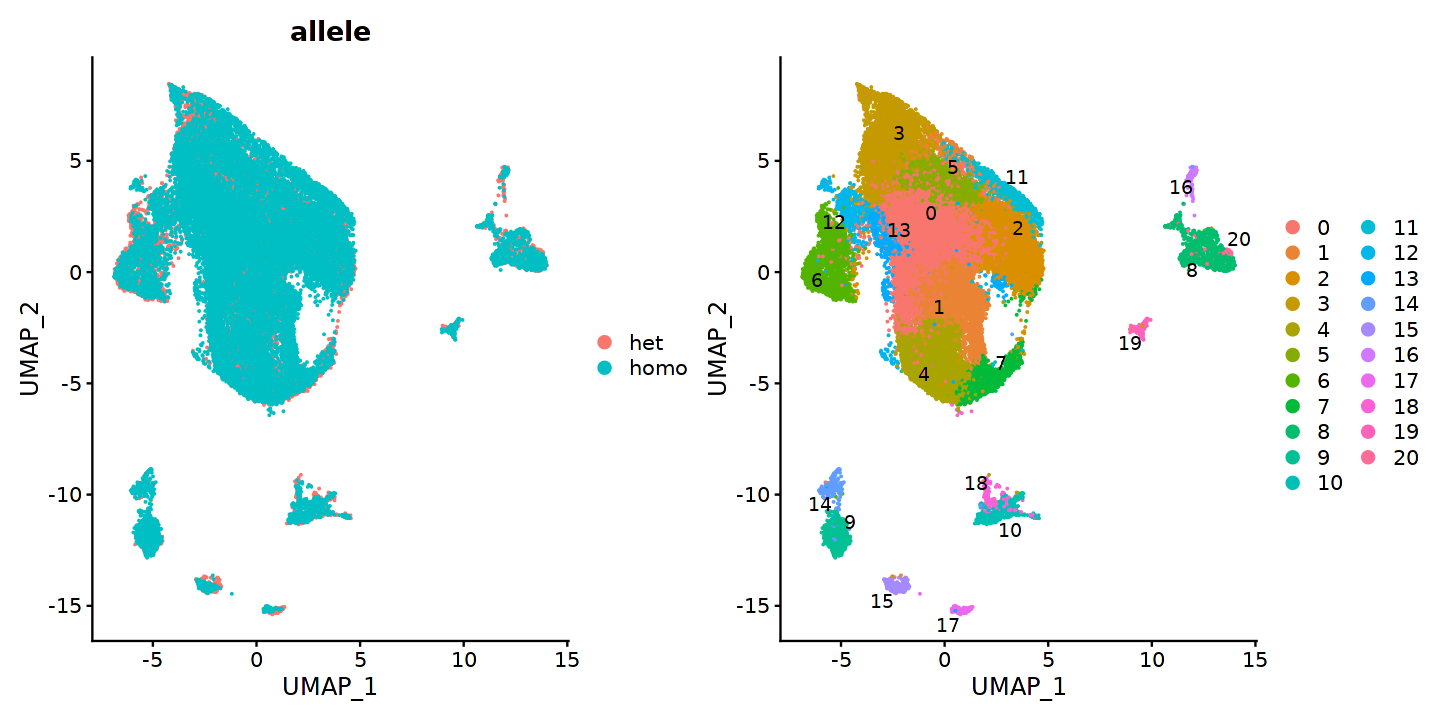

In [100]:
options(repr.plot.height=6, repr.plot.width=12, res=150 ) 
p1 <- DimPlot(neuro.combined, reduction = "umap", group.by = 'allele')
p2 <- DimPlot(neuro.combined, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

In [102]:
saveRDS(
    neuro.combined, 
    glue::glue(
        '/home/hsarkar/Projects/neuroblastoma_analysis/results',
        '/seurat/neuroblast_5_samples_cc_regressed.rds'
    )
)

In [105]:
neuro.combined.p2 = covert_seurat_to_pagoda_app(
    neuro.combined,
    glue::glue(
        '/home/hsarkar/Projects/neuroblastoma_analysis/results',
        '/seurat/Neuroblastoma_Mouse_5_Samples.bin'
    ),
    app.title='Neuroblastoma_Mouse_5_Samples',
    n.cores=20
)

40044 cells, 18780 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

2751 overdispersed genes ... 2751

persisting ... 

done.

running PCA using 3000 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


Estimating embeddings.


Warning message in p2$getEmbedding(type = "PCA", embeddingType = "tSNE", perplexity = perplexity, :
“Too many cells to pre-calculate correlation distances, switching to L2. Please consider using UMAP.”
running tSNE using 20 cores:




creating space of type angular done
adding data ... done
building index ... done
querying ... done


Using multilevel clustering for PCA space




In [106]:
saveRDS(neuro.combined.p2,
        glue::glue(
        '/home/hsarkar/Projects/neuroblastoma_analysis/results',
        '/seurat/Neuroblastoma_Mouse_5_Samples_Seurat_to_Pagoda.rds'
        ))

# Please find the app with 5 samples [here](http://pklab.med.harvard.edu/nikolas/pagoda2/frontend/current/pagodaURL/index.html?fileURL=http://pklab.med.harvard.edu/hirak/public_html/ThMYCN/Neuroblastoma_Mouse_5_Samples.bin)

### Make seurat object list from adrenal samples

In [59]:
file.names = c(
'adrenal_70' = '/home/hsarkar/Projects/ThMYCN/PMID33833454/GSM5067113_10x70.raw_feature_bc_matrix.h5',
'adrenal_71' = '/home/hsarkar/Projects/ThMYCN/PMID33833454/GSM5067114_10x71.raw_feature_bc_matrix.h5',
'adrenal_72' = '/home/hsarkar/Projects/ThMYCN/PMID33833454/GSM5067115_10x72.raw_feature_bc_matrix.h5'
)

raw.objs = lapply(names(file.names), function(fname){
  f = file.names[[fname]]
  raw.count = Read10X_h5(f)
  colnames(raw.count) = paste(fname, colnames(raw.count), sep="_")
  
  mito.genes = grep(pattern = "^mt-", x = rownames(raw.count), value = TRUE, ignore.case = TRUE)
  rpl.genes = grep(pattern = "^rpl", x = rownames(raw.count), value = TRUE, ignore.case = TRUE)
  rps.genes = grep(pattern = "^rps", x = rownames(raw.count), value = TRUE, ignore.case = TRUE)
  genes.removed = union(mito.genes, rpl.genes)
  genes.removed = union(genes.removed, rps.genes)
  raw.count = raw.count[setdiff(rownames(raw.count), genes.removed),]
  rownames(raw.count) = toupper( rownames(raw.count) )
  
  raw.count
})
names(raw.objs) = names(file.names)

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”
Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”
Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”


In [60]:
seurat.adrenal.obj.list = lapply(names(raw.objs),function(sample.name)  CreateSeuratObject(
    counts = raw.objs[[sample.name]],
    min.cells = 3, 
    min.features = 500
))

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”


In [61]:
names(seurat.adrenal.obj.list) = names(raw.objs)

In [62]:
s.genes.selected = intersect(seurat.adrenal.obj.list[[1]] %>% rownames,  s.genes )
g2m.genes.selected = intersect(seurat.adrenal.obj.list[[1]] %>% rownames,  g2m.genes )

In [63]:
seurat.adrenal.obj.list <- lapply(X = seurat.adrenal.obj.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
    x <- ScaleData(x, features = rownames(x))
    x <- RunPCA(
        x, 
        features = VariableFeatures(x), 
         ndims.print = 6:10, 
         nfeatures.print = 10
    )
    x <-  CellCycleScoring(
        x, 
        s.features = s.genes.selected, 
        g2m.features = g2m.genes.selected, 
        set.ident = TRUE
    )
    
    x <-  ScaleData(
        x, 
        vars.to.regress = c("S.Score", "G2M.Score"), 
        features = VariableFeatures(x))
})

Centering and scaling data matrix

PC_ 6 
Positive:  NTRK1, PPP1R1C, SCN9A, SYT13, ISL2, THSD7B, ISLR2, RD3, P2RX3, GAL 
Negative:  DBH, SYTL4, PHOX2A, DGKK, EPAS1, SLC18A1, HAND1, HAND2, SLC18A2, GCH1 
PC_ 7 
Positive:  LECT1, COL11A2, MATN1, ACAN, HAPLN1, CMTM5, COL9A3, NDRG2, 3110079O15RIK, COL2A1 
Negative:  TOP2A, UBE2C, CCNB1, TPX2, NUSAP1, BIRC5, CENPF, SPC25, CENPE, MKI67 
PC_ 8 
Positive:  ACAN, HAPLN1, COL11A2, MATN1, COL9A3, LECT1, PAPSS2, 3110079O15RIK, COL9A1, MIA 
Negative:  COL1A1, COL3A1, MFAP4, IGFBP4, TPM1, CXCL12, OLFML3, SFRP2, PRRX1, OSR1 
PC_ 9 
Positive:  TNNI3, HSPB7, MYBPC3, MYL3, MYH7, MYL7, PLN, MYH6, MYL2, PKP2 
Negative:  MYOG, CDH15, MYOD1, VGLL2, NEB, PITX3, TMEM8C, GM7325, ATP2A1, CHRNA1 
PC_ 10 
Positive:  TNNI3, MYL3, MYBPC3, HSPB7, PLN, MYL2, MYH6, CSRP3, MYH7, NKX2-5 
Negative:  KDR, ICAM2, GIMAP6, CD93, PLVAP, EMCN, PECAM1, CLDN5, CDH5, ESAM 

Regressing out S.Score, G2M.Score

Centering and scaling data matrix

Centering and scaling data matrix

PC

### Save the objects

In [68]:
saveRDS(
    seurat.obj.list, 
    glue::glue(
        '/home/hsarkar/Projects/neuroblastoma_analysis/results',
        '/seurat/mouse_adrenal_3_samples_seurat_object_list_cc_regressed.rds'
    )
)

saveRDS(
    seurat.adrenal.obj.list, 
    glue::glue(
        '/home/hsarkar/Projects/neuroblastoma_analysis/results',
        '/seurat/mouse_adrenal_3_samples_seurat_object_list_cc_regressed.rds'
    )
)

## Integration

In [69]:
tumor.adrenal.combined = merge(
    seurat.obj.list[[1]], 
    y = c(seurat.obj.list[2:5], seurat.adrenal.obj.list), 
    merge.data = T
)

In [70]:
combined.annotation = tumor.adrenal.combined$orig.ident
combined.annotation[!grepl("adrenal",tumor.adrenal.combined$orig.ident)] = 'tumor'
combined.annotation[grepl("adrenal",tumor.adrenal.combined$orig.ident)] = 'adrenal'

In [71]:
tumor.adrenal.combined$condition = combined.annotation

In [72]:
ifnb.list <- SplitObject( tumor.adrenal.combined , split.by = "condition")

In [73]:
features <- SelectIntegrationFeatures(object.list = ifnb.list)

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



In [74]:
immune.anchors <- FindIntegrationAnchors(object.list = ifnb.list, anchor.features = features)
immune.combined <- IntegrateData(anchorset = immune.anchors)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 40173 anchors

Filtering anchors

	Retained 1922 anchors

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [75]:
DefaultAssay(immune.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
immune.combined <- ScaleData(immune.combined, verbose = FALSE)
immune.combined <- RunPCA(immune.combined, npcs = 30, verbose = FALSE)
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:30)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:30)
immune.combined <- FindClusters(immune.combined, resolution = 0.5)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
09:14:16 UMAP embedding parameters a = 0.9922 b = 1.112

09:14:16 Read 61875 rows and found 30 numeric columns

09:14:16 Using Annoy for neighbor search, n_neighbors = 30

09:14:16 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:14:27 Writing NN index file to temp file /tmp/RtmpUVscZo/file6cd96627ea4c

09:14:27 Searching Annoy index using 1 thread, search_k = 3000

09:14:49 Annoy recall = 100%

09:14:54 Commencing smooth kNN distance calibration using 1 thread

09:15:03 Initializing fr

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 61875
Number of edges: 2206125

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9281
Number of communities: 27
Elapsed time: 27 seconds


1 singletons identified. 26 final clusters.



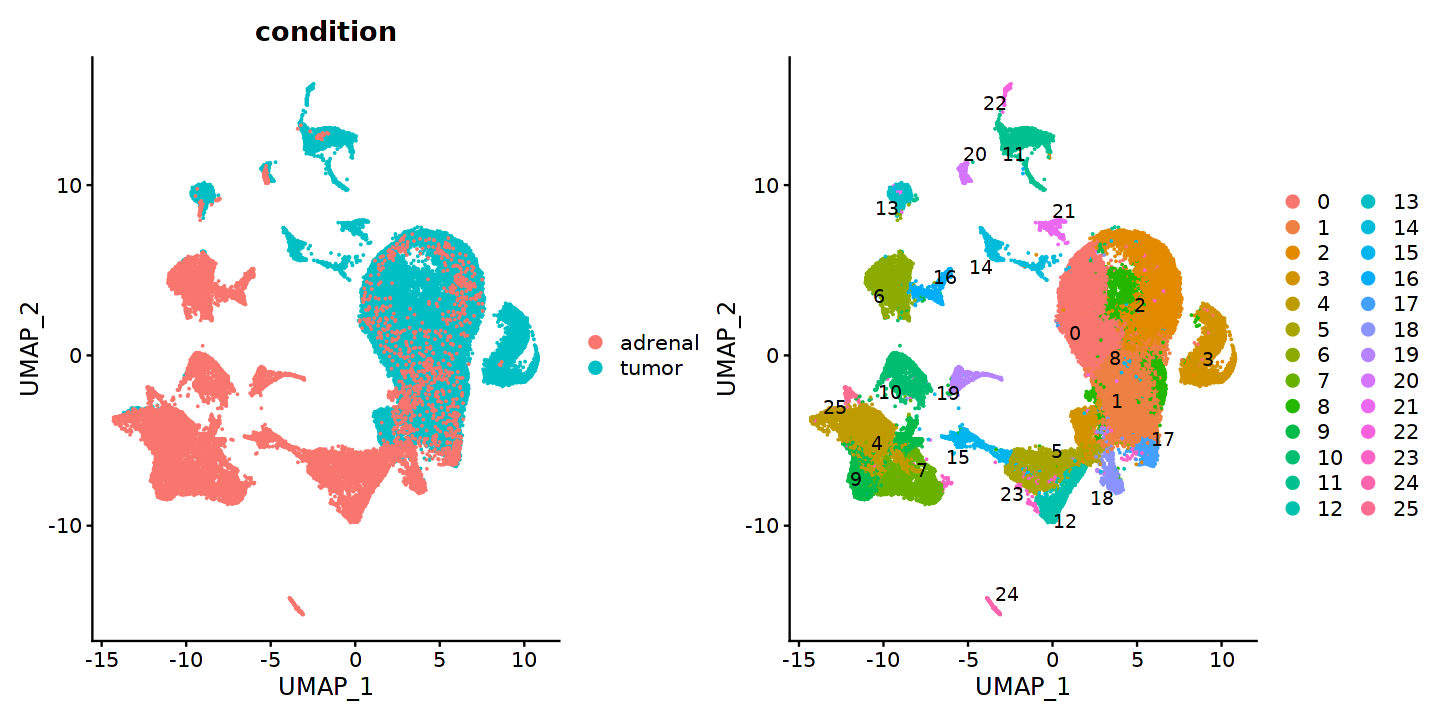

In [76]:
options(repr.plot.height=6, repr.plot.width=12, res=150 ) 
p1 <- DimPlot(immune.combined, reduction = "umap", group.by = "condition")
p2 <- DimPlot(immune.combined, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

In [77]:
annotations = openxlsx::read.xlsx(
    glue::glue(
        '/home/hsarkar/Projects/ThMYCN/Sheets/',
        'combined_diff_up_reg_v2 - Annotations.xlsx'
    ))
annotations = annotations$Annotation

In [78]:
conos.8 = readRDS(
    '/home/hsarkar/Projects/ThMYCN/combined_conos_app_v2_conos.rds'
)
tmp = conos.8$clusters$leiden$groups 
conos.8$clusters$leiden$groups  = annotations[tmp]
names(conos.8$clusters$leiden$groups) = names(tmp)
conos.8$clusters$leiden$groups = as.factor(conos.8$clusters$leiden$groups)
annot.8 = conos.8$clusters$leiden$groups

names(annot.8) = sub('(^[^_]+_[^_]+)_(.*)$', '\\2', names(annot.8))

In [79]:
immune.combined$clusters = annot.8

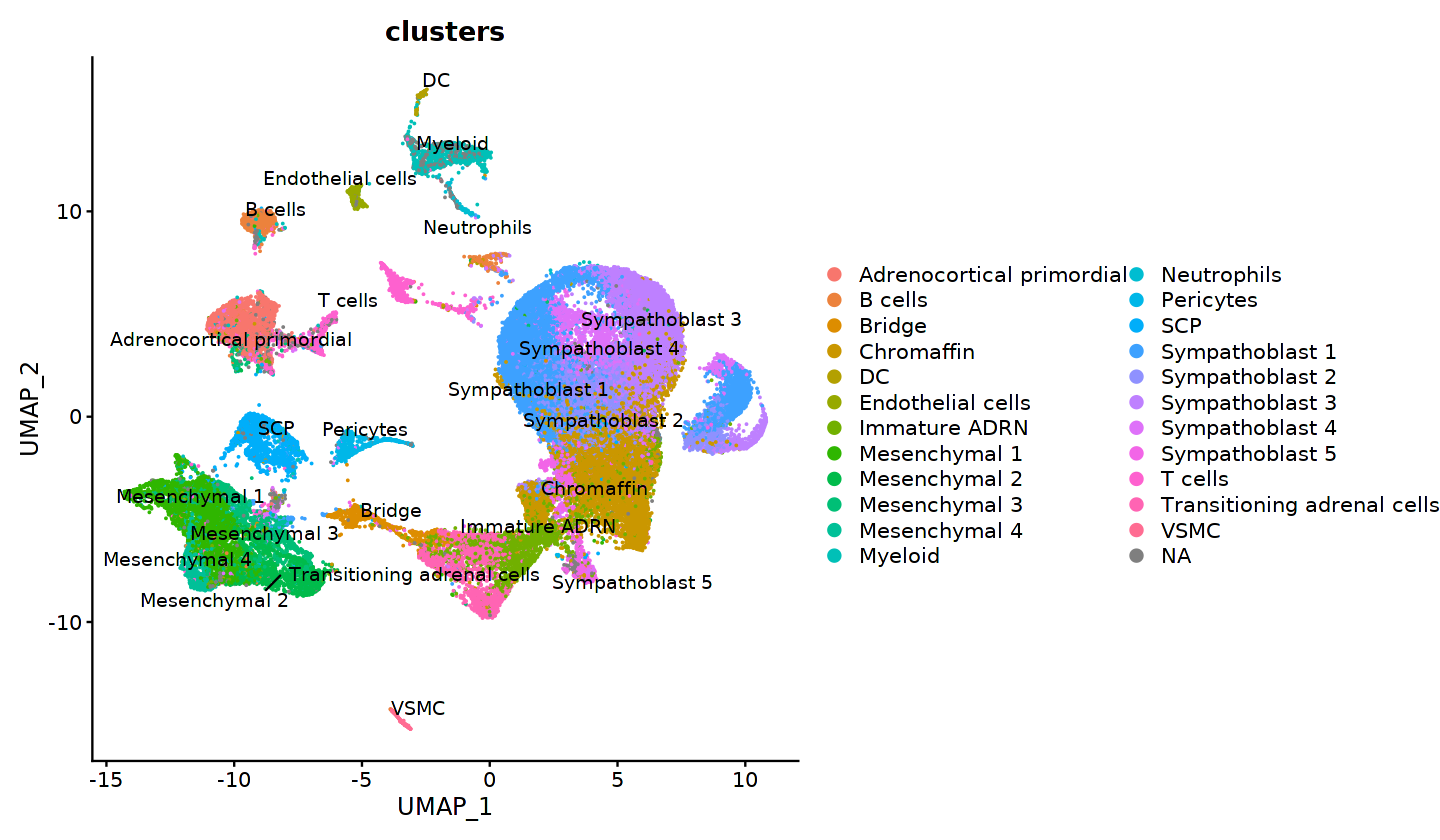

In [80]:
options(repr.plot.height=7, repr.plot.width=12, res=150 ) 
DimPlot(immune.combined, 
        reduction = "umap", 
        group.by = "clusters",
        label = TRUE, 
        repel = TRUE
       )

In [81]:
saveRDS(
    immune.combined, 
    glue::glue(
        '/home/hsarkar/Projects/neuroblastoma_analysis/',
        'results/seurat/mouse_nb_adrenal_8_samples_seurat_cc_regressed.rds'
    )
)

### Subsample proportionally 

In [124]:
immune.combined.downsampled.cells = merge(
    immune.combined$clusters %>% data.frame %>%
    tibble::rownames_to_column(var='cell') %>%
    magrittr::set_colnames(c('cell','cell_type')),
    
    immune.combined$clusters %>% data.frame %>%
    tibble::rownames_to_column(var='cell') %>%
    magrittr::set_colnames(c('cell','cell_type')) %>% 
    count(cell_type) ,
    by = 'cell_type'
    ) %>% sample_n(10000, weight = n) %>%
    pull(cell)

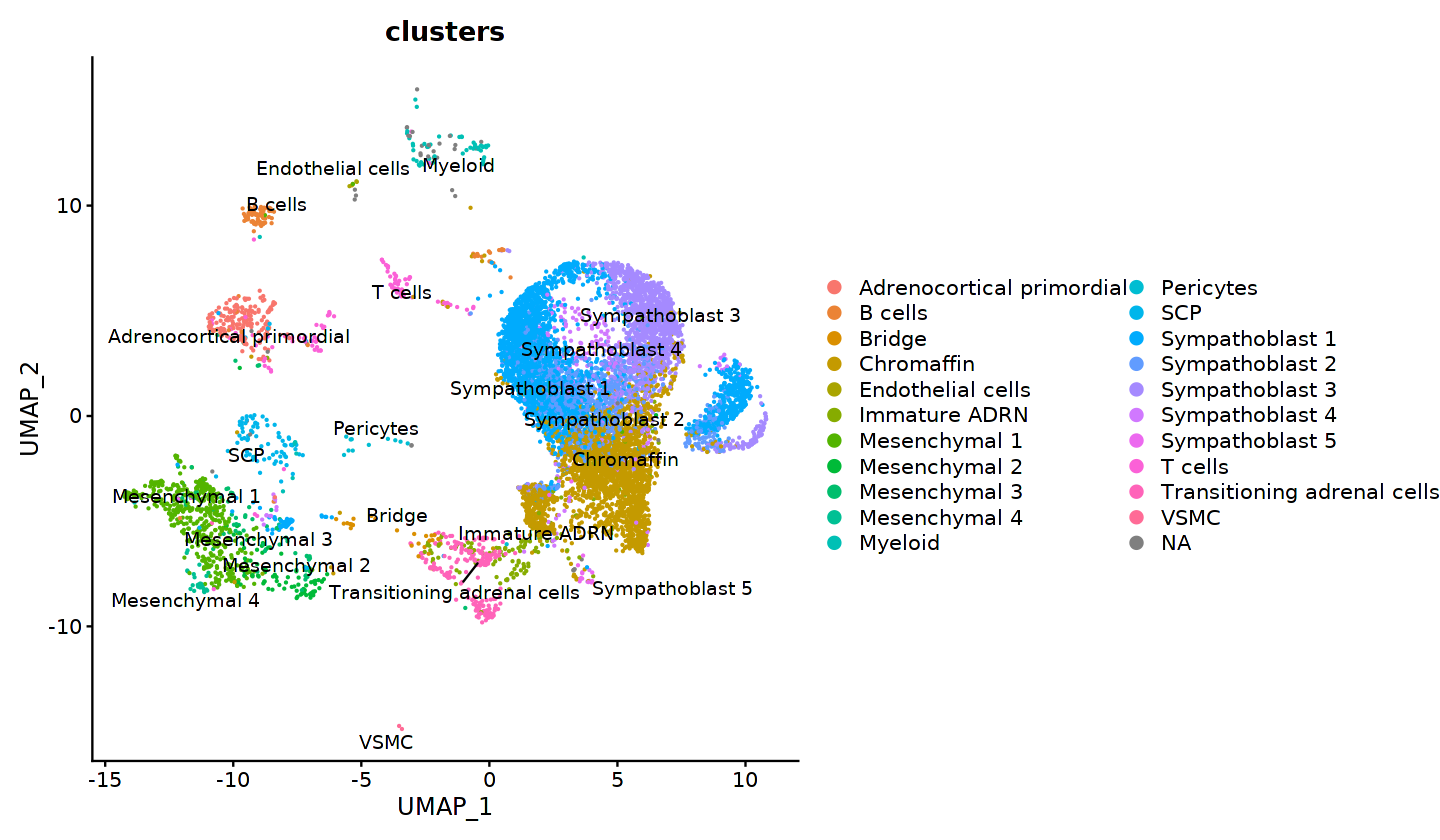

In [125]:
options(repr.plot.height=7, repr.plot.width=12, res=150 ) 
DimPlot(immune.combined, 
        cells = immune.combined.downsampled.cells,
        reduction = "umap", 
        group.by = "clusters",
        label = TRUE, 
        repel = TRUE
       )

In [126]:
immune.combined.downsampled = immune.combined[,immune.combined.downsampled.cells]

In [128]:
immune.combined.downsampled.p2 = covert_seurat_to_pagoda_app(
    immune.combined.downsampled,
    glue::glue(
        '/home/hsarkar/Projects/neuroblastoma_analysis/results',
        '/seurat/Neuroblastoma_Adrenal_Mouse_8_Samples_10K_cells.bin'
    ),
    app.title='Neuroblastoma_Adrenal_Mouse_8_Samples_10K',
    n.cores=20
)

10000 cells, 21457 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

1406 overdispersed genes ... 1406

persisting ... 

done.

running PCA using 3000 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


Estimating embeddings.


running tSNE using 20 cores:




creating space of type angular done
adding data ... done
building index ... done
querying ... done


Using multilevel clustering for PCA space




## 10K subsampled pagoda app [here](http://pklab.med.harvard.edu/nikolas/pagoda2/frontend/current/pagodaURL/index.html?fileURL=http://pklab.med.harvard.edu/hirak/public_html/ThMYCN/Neuroblastoma_Adrenal_Mouse_8_Samples_10K_cells.bin)

In [82]:
library(pagoda2)
library(igraph)


Attaching package: ‘pagoda2’


The following objects are masked from ‘package:conos’:

    buildWijMatrix, projectKNNs, sgdBatches




In [83]:
tumor_adrenal_8_p2 = basicP2proc(
    immune.combined@assays$RNA@counts, 
    n.cores = 10
)

61875 cells, 21457 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

3462 overdispersed genes ... 3462

persisting ... 

done.

running PCA using 3000 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


Estimating embeddings.


Warning message in p2$getEmbedding(type = "PCA", embeddingType = "tSNE", perplexity = perplexity, :
“Too many cells to pre-calculate correlation distances, switching to L2. Please consider using UMAP.”
running tSNE using 10 cores:




creating space of type angular done
adding data ... done
building index ... done
querying ... done


In [84]:
go.env <- p2.generate.human.go(tumor_adrenal_8_p2)

In [85]:
tumor_adrenal_8_p2$clusters$PCA$seurat_cluster = as.factor(
    immune.combined@meta.data$seurat_cluster
)
names(tumor_adrenal_8_p2$clusters$PCA$seurat_cluster) = rownames(immune.combined@meta.data)

tumor_adrenal_8_p2$embeddings$PCA$tSNE = as.matrix(
    immune.combined@reductions$umap@cell.embeddings)
    #p2$embeddings$PCA = as.matrix(p2$embeddings$PCA@cell.embeddings)

tumor_adrenal_8_p2$clusters$PCA$timepoint = as.factor(immune.combined@meta.data$orig.ident)
names(tumor_adrenal_8_p2$clusters$PCA$timepoint) = rownames(immune.combined@meta.data)

tumor_adrenal_8_p2$embeddings$PCA$tSNE = as.matrix(
    immune.combined@reductions$umap@cell.embeddings
)

In [86]:
cat('Calculating hdea...\n')
hdea <- tumor_adrenal_8_p2$getHierarchicalDiffExpressionAspects(
    type='PCA',
    clusterName='multilevel',
    z.threshold=3, 
    n.cores = 30
)

Calculating hdea...


Using multilevel clustering for PCA space




In [88]:
extraWebMetadata = NULL
    
metadata.forweb <- list();
metadata.forweb$timepoint <- p2.metadata.from.factor(
    tumor_adrenal_8_p2$clusters$PCA$timepoint,
    displayname='timepoint'
)
metadata.forweb$leiden <- p2.metadata.from.factor(
    tumor_adrenal_8_p2$clusters$PCA$seurat_cluster,
    displayname='seurat_cluster'
)
metadata.forweb$multilevel <- p2.metadata.from.factor(
    tumor_adrenal_8_p2$clusters$PCA$multilevel,
    displayname='multilevel'
)
metadata.forweb <- c(metadata.forweb, extraWebMetadata)
genesets <- hierDiffToGenesets(hdea)
appmetadata = list(apptitle='Neuroblastoma_Adrenal_Mouse_8_Samples')

In [89]:
cat('Making KNN graph...\n')
    #p2$makeGeneKnnGraph(n.cores=n.cores)
p2w = make.p2.app(
    tumor_adrenal_8_p2, 
    additionalMetadata = metadata.forweb, 
    geneSets = genesets, 
    dendrogramCellGroups = tumor_adrenal_8_p2$clusters$PCA$multilevel, 
    show.clusters=F, 
    appmetadata = appmetadata
)

Making KNN graph...


In [90]:
p2w$serializeToStaticFast(binary.filename = glue::glue(
    '/home/hsarkar/Projects/neuroblastoma_analysis/',
    'results/seurat/Neuroblastoma_Adrenal_Mouse_8_Samples.bin'
))

NULL

# Please find the app with 8 samples [here](http://pklab.med.harvard.edu/nikolas/pagoda2/frontend/current/pagodaURL/index.html?fileURL=http://pklab.med.harvard.edu/hirak/public_html/ThMYCN/Neuroblastoma_Adrenal_Mouse_8_Samples.bin)

In [91]:
saveRDS(
    tumor_adrenal_8_p2,
    glue::glue(
        '/home/hsarkar/Projects/neuroblastoma_analysis/',
        'results/seurat/Neuroblastoma_Adrenal_Mouse_8_Samples_seurat_pagoda.rds'
    ))